## Analyzing Entropy for a Random Circuit
Considering circuits with different number of Qubits and varying Depths

**1) Configure Qiskit Runtime Service, and Input Parameters**
<br/>
Input Parameters:
- Range for number of qubits
- Circuit depth range
- Number of circuit runs

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.fake_provider import GenericBackendV2
from config import api_key
import numpy as np

# Save an IBM Quantum account as your default account, and Load saved credentials
QiskitRuntimeService.save_account(
    channel="ibm_quantum", token=api_key, set_as_default=True, overwrite=True
)
service = QiskitRuntimeService()

# Define Input Parameters
num_q = np.arange(2, 6, 1)
depths = np.arange(3, 61, 1)
runs = 20

In [ ]:
service.backends()

**2) Generate Random Circuits and Compute Entropy**

In [3]:
from qiskit.providers.basic_provider import BasicSimulator
import pandas as pd
from random_circuit import eagle_gate_set, basis_gate_set
from random_circuit import get_random_circuit
from entropy import get_average_entropy
from utils import get_measurement

# Define backend to run jobs
# backend = BasicSimulator()
# backend = service.backend("ibm_osaka")

# Choose a set of gates to build circuit
gate_set = eagle_gate_set

# Calculate entropy - Looping over depth and number of qubits
data_list = []
for n in num_q:
    for d in depths:
        circuit = get_random_circuit(n, d, gate_set)
        backend = GenericBackendV2(num_qubits=n)
        measurement = get_measurement(circuit, runs, backend)
        entropy = get_average_entropy(measurement)
        data_list.append(
            {
                "Num": n,
                "depth": d,
                "entropy": entropy,
                "circuit": circuit,
                "measurement": measurement,
            }
        )
data = pd.DataFrame(data_list)

# Print the DataFrame
print(data)

     Num  depth   entropy                                            circuit  \
0      2      3  0.692356  ((Instruction(name='x', num_qubits=1, num_clbi...   
1      2      4  0.882100  ((Instruction(name='id', num_qubits=1, num_clb...   
2      2      5  0.781751  ((Instruction(name='ecr', num_qubits=2, num_cl...   
3      2      6  0.694227  ((Instruction(name='id', num_qubits=1, num_clb...   
4      2      7  0.801794  ((Instruction(name='rz', num_qubits=1, num_clb...   
..   ...    ...       ...                                                ...   
227    5     56  0.911437  ((Instruction(name='id', num_qubits=1, num_clb...   
228    5     57  0.931046  ((Instruction(name='id', num_qubits=1, num_clb...   
229    5     58  0.929788  ((Instruction(name='ecr', num_qubits=2, num_cl...   
230    5     59  0.915668  ((Instruction(name='id', num_qubits=1, num_clb...   
231    5     60  0.916138  ((Instruction(name='id', num_qubits=1, num_clb...   

                                       

**3) Plot Entropy vs Depth for different Number of Qubits**

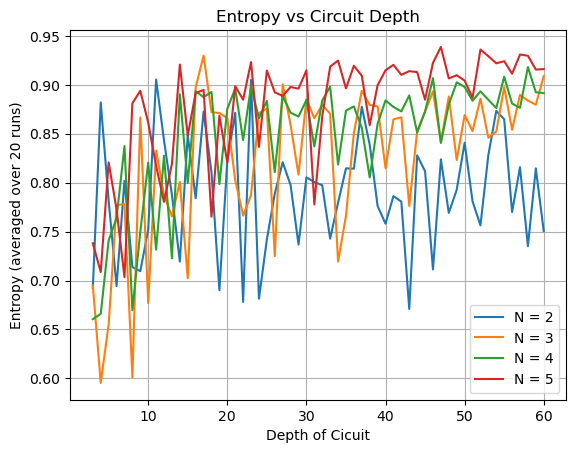

In [4]:
import matplotlib.pyplot as plt

# Plotting
plt.title("Entropy vs Circuit Depth")
plt.xlabel("Depth of Cicuit")
plt.ylabel("Entropy (averaged over " + str(runs) + " runs)")

for N in num_q:
    filtered_df = data[data["Num"] == N]
    lbl = "N = " + str(N)
    plt.plot(filtered_df["depth"], filtered_df["entropy"], label=lbl)

plt.grid(True)
plt.legend()
plt.show()

**4) Find circuit with Lowest and Highest Entropy for given Depth**

In [5]:
from entropy import get_extreme_entropy_data

# Printing circuit with highest and lowest entropy
depth = 24
highest, lowest = get_extreme_entropy_data(data, depth)
print("Circuit with the highest entropy = " + str(highest["entropy"]) + " for depth" + str(depth) + ":")
print(highest["circuit"])
print("Circuit with the lowest entropy = " + str(lowest["entropy"]) + " for depth "+ str(depth) + ":")
print(lowest["circuit"])

Circuit with the highest entropy = 0.8711043302465418 for depth24:
     ┌────────────┐┌───┐┌──────┐    ┌───┐     ┌────┐          ┌──────┐┌───┐»
q_0: ┤ Rz(5.8046) ├┤ I ├┤0     ├────┤ X ├─────┤ √X ├──────────┤1     ├┤ I ├»
     └───┬───┬────┘├───┤│      │    ├───┤     ├───┬┘┌───┐┌───┐│      │├───┤»
q_1: ────┤ X ├─────┤ I ├┤  Ecr ├────┤ I ├─────┤ I ├─┤ I ├┤ X ├┤  Ecr ├┤ I ├»
         ├───┤     ├───┤│      │┌───┴───┴────┐├───┤ └───┘└───┘│      │├───┤»
q_2: ────┤ X ├─────┤ I ├┤1     ├┤ Rz(5.7233) ├┤ I ├───────────┤0     ├┤ X ├»
         └───┘     └───┘└──────┘└────────────┘└───┘           └──────┘└───┘»
«         ┌───┐         ┌───┐      ┌────┐      ┌──────┐┌──────┐┌───┐ »
«q_0: ────┤ X ├─────────┤ I ├──────┤ √X ├──────┤0     ├┤1     ├┤ X ├─»
«         ├───┤     ┌───┴───┴────┐┌┴────┴┐┌───┐│      ││      │├───┤ »
«q_1: ────┤ I ├─────┤ Rz(2.4024) ├┤1     ├┤ I ├┤  Ecr ├┤  Ecr ├┤ X ├─»
«     ┌───┴───┴────┐├────────────┤│  Ecr │└───┘│      ││      │├───┴┐»
«q_2: ┤ Rz(3.9811) ├┤ Rz(5.0706) ├┤0   

**5) Lowest and Highest Entropy circuit analysis - Measurement Bar Graph and Bloch Sphere**

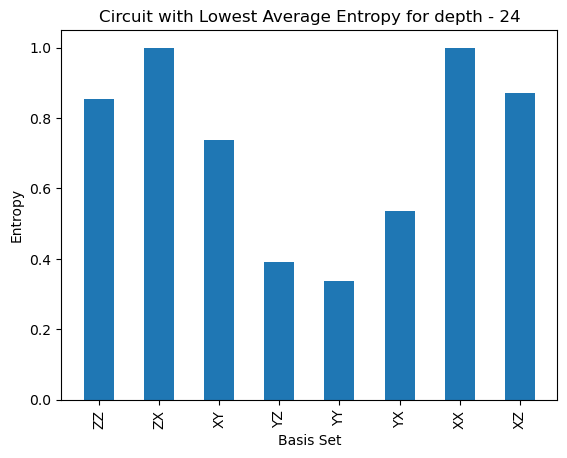

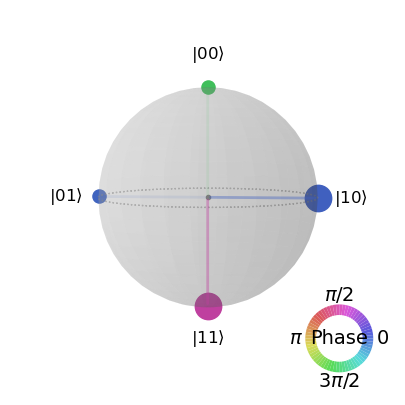

In [6]:
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from entropy import get_entropy_list

# Lowest Entropy Circuit - Measurement Histogram and Bloch Sphere
low_entropy = get_entropy_list(lowest["measurement"])
basis = list(low_entropy.keys())
entropy_low = list(low_entropy.values())
plt.title("Circuit with Lowest Average Entropy for depth - " + str(depth))
plt.xlabel("Basis Set")
plt.ylabel("Entropy")
plt.bar(basis, entropy_low, width=0.5)
plt.xticks(rotation='vertical')
plt.show()

density_matrix = DensityMatrix.from_instruction(lowest["circuit"])
# plot_bloch_multivector(density_matrix)
plot_state_qsphere(state=density_matrix, figsize=(5, 5))

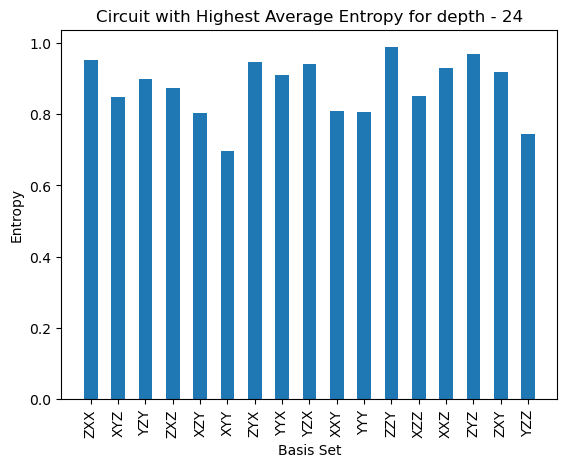

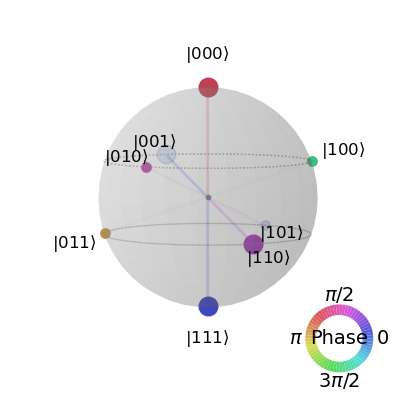

In [9]:
# Highest Entropy Circuit - Measurement Histogram and Bloch Sphere
high_entropy = get_entropy_list(highest["measurement"])
basis = list(high_entropy.keys())
entropy_high = list(high_entropy.values())
plt.title("Circuit with Highest Average Entropy for depth - " + str(depth))
plt.xlabel("Basis Set")
plt.ylabel("Entropy")
plt.bar(basis, entropy_high, width=0.5)
plt.xticks(rotation='vertical')
plt.show()

density_matrix = DensityMatrix.from_instruction(highest["circuit"])
# plot_bloch_multivector(density_matrix)
plot_state_qsphere(state=density_matrix, figsize=(5, 5))

**6) Entropy Bar Graphs at Different Depths for Different Number of Qubits**

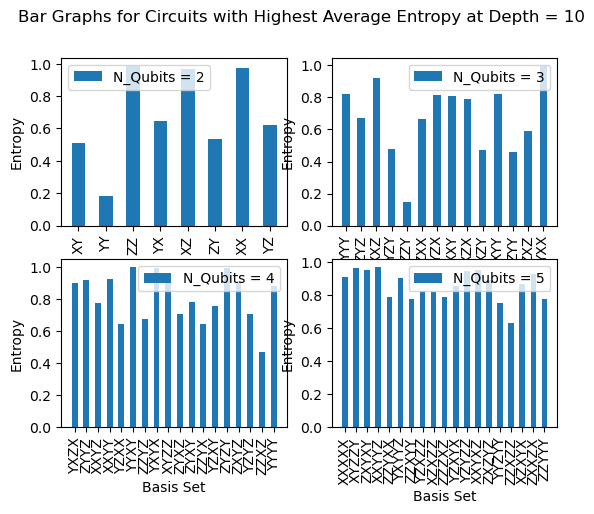

In [10]:
# Bar Graphs at Different Depths for Highest Entropy Circuits

# d_arr = [10, 27, 43, 60]
d = 10
i = 1
plt.suptitle("Bar Graphs for Circuits with Highest Average Entropy at Depth = " + str(d))
for N in num_q:
    filtered_df = data[data["Num"] == N] 
    high, L = get_extreme_entropy_data(filtered_df, d)
    high_entropy = get_entropy_list(high["measurement"])
    basis = list(high_entropy.keys())
    entropy = list(high_entropy.values())
    plt.subplot(2,2,i)
    lbl = "N_Qubits = " + str(N)
    plt.xlabel("Basis Set")
    plt.ylabel("Entropy")
    plt.bar(basis, entropy, width=0.5, label=lbl)
    plt.legend()
    plt.xticks(rotation='vertical')
    i += 1
plt.show()

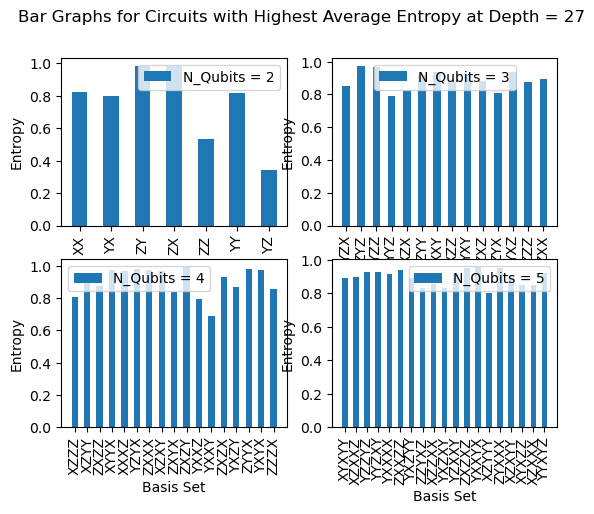

In [12]:
# Bar Graphs at Different Depths for Highest Entropy Circuits

# d_arr = [10, 27, 43, 60]
d = 27
i = 1
plt.suptitle("Bar Graphs for Circuits with Highest Average Entropy at Depth = " + str(d))
for N in num_q:
    filtered_df = data[data["Num"] == N] 
    H, L = get_extreme_entropy_data(filtered_df, d)
    high_entropy = get_entropy_list(H["measurement"])
    basis = list(high_entropy.keys())
    entropy = list(high_entropy.values())
    plt.subplot(2,2,i)
    lbl = "N_Qubits = " + str(N)
    plt.xlabel("Basis Set")
    plt.ylabel("Entropy")
    plt.bar(basis, entropy, width=0.5, label=lbl)
    plt.legend()
    plt.xticks(rotation='vertical')
    i += 1
plt.show()

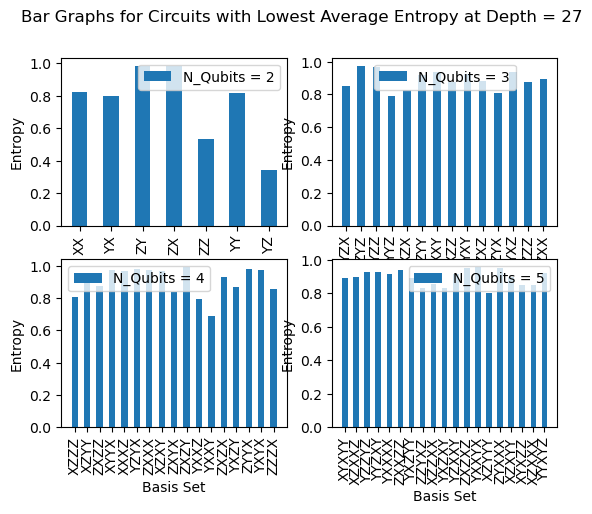

In [11]:
# Bar Graphs at Different Depths for Highest Entropy Circuits

# d_arr = [10, 27, 43, 60]
d = 27
i = 1
plt.suptitle("Bar Graphs for Circuits with Lowest Average Entropy at Depth = " + str(d))
for N in num_q:
    filtered_df = data[data["Num"] == N]
    H, low = get_extreme_entropy_data(filtered_df, d)
    high_entropy = get_entropy_list(low["measurement"])
    basis = list(high_entropy.keys())
    entropy = list(high_entropy.values())
    plt.subplot(2,2,i)
    lbl = "N_Qubits = " + str(N)
    plt.xlabel("Basis Set")
    plt.ylabel("Entropy")
    plt.bar(basis, entropy, width=0.5, label=lbl)
    plt.legend()
    plt.xticks(rotation='vertical')
    i += 1
plt.show()